# LINCS Publications & Citations Report

*Created by Brian M. Schilder, Moshe Silverstein, and Alexandra Keenan on 09/22/2018.*

In [52]:
%matplotlib inline

import sys
print (sys.version)
# token: 428145730f2d00b0596bd2521918df095fc272a23500acb4
import os
os.getcwd()
os.chdir('../LINCS-Publications-Report')

3.6.5 (v3.6.5:f59c0932b4, Mar 28 2018, 03:03:55) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]


## Summary
- Plots:
	- Publications over time
	- Citations over time


- Repeat these plots for each of the following groupings:
	- Aggregated across internal LINCS centers

	- Divided amongst internal LINCS centers (label by center, not PI)
		1. Data Coordination and Integration Center (Mount Sinai, Avi Ma’ayan)
		2. Drug Toxicity Signature Generation Center (Mount Sinai, Ravi Iyengar)
		3. LINCS Proteomic Characterization Center for Signaling and Epigenetics (Broad Institute, Jacob Jaffe)
		4. Microenvironment Perturbagen (MEP) LINCS Center (Oregon Health & Science University, Joe Gray)
		5.	HMS LINCS Center (Peter Sorger)
		6.	LINCS Center for Transcriptomics (Broad Institute, Todd Golub)
		7.	NeuroLINCS Center  (UC-Irvine, Leslie Thompson)
	- Across all groups external to LINCS (E.g. papers that used L1000, Canvas Browser).; 

### Import Data

In [53]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
sn.set_style('whitegrid')
sn.set(font_scale=1.5) 
# Author info from LINCS database (collected 
authors = pd.read_table('authors.tsv')
authors.rename(columns={'id':'author_id'}, inplace=True)

authors_pubs = pd.read_table('authors_publications.tsv')
authorKey = authors.merge(authors_pubs, on='author_id')


# Publications (internal and external to the LINCS centers)
# Collected by Moshe Silverstein
## had to manually correct a couple errors in file
pubs = pd.read_table('publications.tsv') 
# Fill missing pub ids
maxID = int(max(pubs['id']))
fillerIDs = pd.Series(range(maxID, maxID+sum(pd.isnull(pubs['id'])) ))
pubs.fillna(fillerIDs, inplace=True)
# Rename cols
pubs.rename(columns={'id':'publication_id'}, inplace=True)  
# pubs['publication_id'] = pubs['publication_id'].astype(int)

# Get authors and concatenate
pubs_tmp = pubs.merge(authorKey, on='publication_id')
authorsConcat = pubs_tmp.groupby('publication_id')['name'].apply(lambda x: "%s" % ', '.join(x)).reset_index()
authorsConcat.rename(columns={'name':'authors'}, inplace=True) 
pubs = pubs.merge(authorsConcat, on='publication_id').drop_duplicates()  
pubs.columns
# Additional publications (internal and external to the LINCS centers)
#  collected by Alexandra Keenan
pubs2 = pd.read_csv('additional_pubs.csv')

def externalInternal(val):
    if val == 'outside':
        return 0
    else:
        return 1
pubs2['center_pub'] = pubs2['center'].apply(externalInternal)
pubs2 = pubs2.rename(columns={'PMID':'pm_id', 'year':'year_published', 'title':'article_name'})
pubs2['publication_id'] = max(pubs['publication_id'].astype(int)) 
pubs_extended = pd.concat([pubs, pubs2],axis=0,  ignore_index=True) 


## Get Citations from PubMed API
Documentation: 
- https://www.ncbi.nlm.nih.gov/pmc/tools/cites-citedby/
- https://www.ncbi.nlm.nih.gov/books/NBK25497/

Note: To use the API you must first register your tool and email with NCBI by emailing eutilities@ncbi.nlm.nih.gov;

In [54]:
pubmed_url = 'http://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi?'+\
             'dbfrom=pubmed&linkname=pmc_pmc_citedby&id='

tool = 'MaayanLab'
email = 'brian_schilder@alumni.brown.edu' 
# You can register an API in your NCBI account settings to submit up to 10 requests/second
# ,instead of the default 3 requests/second
APIkey = 'ff789492667dabdb0c98afa776eb2090cc08'
PMClist = pubs_extended['pmc_id'].str.strip('PMC').str.strip(' ').astype(str)
PMClist = PMClist[PMClist!='nan']
urls = pubmed_url+PMClist +'&tool='+tool+'&email='+email+'&api_key='+APIkey
url=urls[0]

from requests import get
import xmltodict   
import time
citations={} 
def getCitations(url): 
    PMC = url.split('&id=')[1].split("&tool")[0] 
    response = get(str(url))
    citDict = xmltodict.parse(response.content)
    try:
        citationInfo = citDict['eLinkResult']['LinkSet']['LinkSetDb']['Link']
        allCitations = [x['Id'] for x in citationInfo ] 
        citations[PMC] = len(set(allCitations)) # Get unique citations
        status = str(len(set(allCitations)))+' citations found'
        # Can only submit up to 10 requests/second
        time.sleep(.11)
    except:
        citations[PMC] = 0 
        status = 'None found'
    print("Extracting Citations for PMC : "+PMC+"........ "+status)
    return citations

res = map(getCitations, urls)
results = list(res) 

results_df = pd.DataFrame(pd.Series(results[0],name='n_citations')  )  
results_df['pmc_id'] = 'PMC'+results_df.index  
 

Extracting Citations for PMC : 4456804........ 6 citations found


Extracting Citations for PMC : 4243058........ 67 citations found


Extracting Citations for PMC : 4380931........ 18 citations found


Extracting Citations for PMC : 4270428........ 4 citations found


Extracting Citations for PMC : 4383998........ 291 citations found


Extracting Citations for PMC : 4607730........ 8 citations found


Extracting Citations for PMC : 4201337........ 27 citations found


Extracting Citations for PMC : 4221125........ 3 citations found
Extracting Citations for PMC : 4274604........ None found


Extracting Citations for PMC : 4179751........ 19 citations found


Extracting Citations for PMC : 4156235........ 46 citations found


Extracting Citations for PMC : 4153537........ 21 citations found


Extracting Citations for PMC : 4137659........ 4 citations found


Extracting Citations for PMC : 4086130........ 63 citations found


Extracting Citations for PMC : 4108877........ 23 citations found


Extracting Citations for PMC : 3990667........ 3 citations found


Extracting Citations for PMC : 4234128........ 16 citations found


Extracting Citations for PMC : 3771683........ 10 citations found


Extracting Citations for PMC : 3637064........ 454 citations found


Extracting Citations for PMC : 3692096........ 9 citations found


Extracting Citations for PMC : 3764016........ 5 citations found
Extracting Citations for PMC : 3609407........ None found


Extracting Citations for PMC : 3615534........ 9 citations found


Extracting Citations for PMC : 3760004........ 35 citations found


Extracting Citations for PMC : 3947796........ 68 citations found


Extracting Citations for PMC : 4098832........ 123 citations found


Extracting Citations for PMC : 3589817........ 33 citations found


Extracting Citations for PMC : 3845839........ 33 citations found


Extracting Citations for PMC : 3799471........ 39 citations found


Extracting Citations for PMC : 3959726........ 75 citations found


Extracting Citations for PMC : 3569091........ 12 citations found


Extracting Citations for PMC : 3855094........ 9 citations found


Extracting Citations for PMC : 3712222........ 19 citations found


Extracting Citations for PMC : 3783590........ 2 citations found


Extracting Citations for PMC : 3782379........ 3 citations found


Extracting Citations for PMC : 3878311........ 8 citations found


Extracting Citations for PMC : 3349233........ 655 citations found


Extracting Citations for PMC : 3428019........ 93 citations found


Extracting Citations for PMC : 3498356........ 18 citations found


Extracting Citations for PMC : 3270411........ 68 citations found


Extracting Citations for PMC : 3105758........ 25 citations found


Extracting Citations for PMC : 3465072........ 47 citations found
Extracting Citations for PMC : 4675694........ None found


Extracting Citations for PMC : 4587398........ 29 citations found


Extracting Citations for PMC : 4737646........ 6 citations found


Extracting Citations for PMC : 4657038........ 7 citations found
Extracting Citations for PMC : 4965338........ None found


Extracting Citations for PMC : 4707261........ 10 citations found


Extracting Citations for PMC : 4858944........ 17 citations found


Extracting Citations for PMC : 4965635........ 10 citations found


Extracting Citations for PMC : 4821530........ 6 citations found


Extracting Citations for PMC : 4461398........ 18 citations found


Extracting Citations for PMC : 3443648........ 8 citations found


Extracting Citations for PMC : 4987924........ 240 citations found


Extracting Citations for PMC : 4887336........ 38 citations found


Extracting Citations for PMC : 4857123........ 4 citations found


Extracting Citations for PMC : 3605723........ 9 citations found


Extracting Citations for PMC : 4784899........ 12 citations found


Extracting Citations for PMC : 4856035........ 4 citations found
Extracting Citations for PMC : 4016950........ None found


Extracting Citations for PMC : 3667614........ 107 citations found


Extracting Citations for PMC : 3376217........ 6 citations found


Extracting Citations for PMC : 3384541........ 58 citations found


Extracting Citations for PMC : 3322972........ 39 citations found


Extracting Citations for PMC : 3465074........ 7 citations found


Extracting Citations for PMC : 4838263........ 13 citations found


Extracting Citations for PMC : 4930834........ 38 citations found


Extracting Citations for PMC : 5389891........ 18 citations found


Extracting Citations for PMC : 4972086........ 6 citations found


Extracting Citations for PMC : 5003654........ 13 citations found


Extracting Citations for PMC : 496526........ 11 citations found
Extracting Citations for PMC : 487650........ None found
Extracting Citations for PMC : 485547........ None found


Extracting Citations for PMC : 490832........ None found


Extracting Citations for PMC : 462586........ 7 citations found


Extracting Citations for PMC : 433301........ 39 citations found
Extracting Citations for PMC : 410386........ None found


Extracting Citations for PMC : 5001780........ 2 citations found


Extracting Citations for PMC : 5052684........ 16 citations found
Extracting Citations for PMC : 491686........ None found
Extracting Citations for PMC : 445744........ None found


Extracting Citations for PMC : 486834........ None found


Extracting Citations for PMC : 5138863........ 45 citations found


Extracting Citations for PMC : 4800742........ 165 citations found


Extracting Citations for PMC : 4976700........ 3 citations found


Extracting Citations for PMC : 4919895........ 2 citations found


Extracting Citations for PMC : 5248573........ 17 citations found


Extracting Citations for PMC : 4829466........ 37 citations found


Extracting Citations for PMC : 4783079........ 6 citations found
Extracting Citations for PMC : 5349314........ None found
Extracting Citations for PMC : 5332957........ None found


Extracting Citations for PMC : 5159530........ None found
Extracting Citations for PMC : 5541064........ None found
Extracting Citations for PMC : 5536358........ None found


Extracting Citations for PMC : 5599787........ None found
Extracting Citations for PMC : 5543336........ None found


Extracting Citations for PMC : 5193106........ 4 citations found
Extracting Citations for PMC : 5355998........ None found


Extracting Citations for PMC : 5634325........ 3 citations found
Extracting Citations for PMC : 5632288........ None found
Extracting Citations for PMC : 5579542........ None found


Extracting Citations for PMC : 5610318........ None found


Extracting Citations for PMC : 5538315........ 6 citations found
Extracting Citations for PMC : 5287226........ None found


Extracting Citations for PMC : 5482631........ 2 citations found
Extracting Citations for PMC : 5493619........ None found


Extracting Citations for PMC : 5662764........ 2 citations found


Extracting Citations for PMC : 5655815........ 3 citations found
Extracting Citations for PMC : 5674849........ None found
Extracting Citations for PMC : 5827688........ None found


Extracting Citations for PMC : 5828078........ None found
Extracting Citations for PMC : 5927625........ None found


### Get publications by API using grant numbers

In [40]:
pubmed_url = 'http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?'+\
            'db=pubmed&term=U54-NS091046%5BGrant+Number%5D'

tool = 'MaayanLab'
email = 'brian_schilder@alumni.brown.edu' 
# You can register an API in your NCBI account settings to submit up to 10 requests/second
# ,instead of the default 3 requests/second
APIkey = 'ff789492667dabdb0c98afa776eb2090cc08' 
granIDs = pd.read_csv('LINCS_centers_by_grant.csv')
urls = pubmed_url+granIDs['grant'] +'&tool='+tool+'&email='+email+'&api_key='+APIkey
url=urls[0]

from requests import get
import xmltodict   
import time
citations={} 
def getCitations(url): 
    PMC = url.split('&id=')[1].split("&tool")[0] 
    response = get(str(url))
    citDict = xmltodict.parse(response.content)
    try:
        citationInfo = citDict['eLinkResult']['LinkSet']['LinkSetDb']['Link']
        allCitations = [x['Id'] for x in citationInfo ] 
        citations[PMC] = len(set(allCitations)) # Get unique citations
        status = str(len(set(allCitations)))+' citations found'
        # Can only submit up to 10 requests/second
        time.sleep(.11)
    except:
        citations[PMC] = 0 
        status = 'None found'
    print("Extracting Citations for PMC : "+PMC+"........ "+status)
    return citations

res = map(getCitations, urls)
results = list(res) 
results_df = pd.DataFrame(pd.Series(results[0],name='n_citations')  )  
results_df['pmc_id'] = 'PMC'+results_df.index  
 

Extracting Citations for PMC : 4456804........ 6 citations found


Extracting Citations for PMC : 4243058........ 67 citations found


Extracting Citations for PMC : 4380931........ 18 citations found


Extracting Citations for PMC : 4270428........ 4 citations found


Extracting Citations for PMC : 4383998........ 291 citations found


Extracting Citations for PMC : 4607730........ 8 citations found


Extracting Citations for PMC : 4201337........ 27 citations found


Extracting Citations for PMC : 4221125........ 3 citations found
Extracting Citations for PMC : 4274604........ None found


Extracting Citations for PMC : 4179751........ 19 citations found


Extracting Citations for PMC : 4156235........ 46 citations found


Extracting Citations for PMC : 4153537........ 21 citations found


Extracting Citations for PMC : 4137659........ 4 citations found


Extracting Citations for PMC : 4086130........ 63 citations found


Extracting Citations for PMC : 4108877........ 23 citations found


Extracting Citations for PMC : 3990667........ 3 citations found


Extracting Citations for PMC : 4234128........ 16 citations found


Extracting Citations for PMC : 3771683........ 10 citations found


Extracting Citations for PMC : 3637064........ 453 citations found


Extracting Citations for PMC : 3692096........ 9 citations found


Extracting Citations for PMC : 3764016........ 5 citations found
Extracting Citations for PMC : 3609407........ None found


Extracting Citations for PMC : 3615534........ 9 citations found


Extracting Citations for PMC : 3760004........ 35 citations found


Extracting Citations for PMC : 3947796........ 68 citations found


Extracting Citations for PMC : 4098832........ 123 citations found


Extracting Citations for PMC : 3589817........ 33 citations found


Extracting Citations for PMC : 3845839........ 33 citations found


Extracting Citations for PMC : 3799471........ 39 citations found


Extracting Citations for PMC : 3959726........ 75 citations found


Extracting Citations for PMC : 3569091........ 12 citations found


Extracting Citations for PMC : 3855094........ 9 citations found


Extracting Citations for PMC : 3712222........ 19 citations found


Extracting Citations for PMC : 3783590........ 2 citations found


Extracting Citations for PMC : 3782379........ 3 citations found


Extracting Citations for PMC : 3878311........ 8 citations found


Extracting Citations for PMC : 3349233........ 655 citations found


Extracting Citations for PMC : 3428019........ 93 citations found


Extracting Citations for PMC : 3498356........ 18 citations found


Extracting Citations for PMC : 3270411........ 68 citations found


Extracting Citations for PMC : 3105758........ 25 citations found


Extracting Citations for PMC : 3465072........ 47 citations found
Extracting Citations for PMC : 4675694........ None found


Extracting Citations for PMC : 4587398........ 29 citations found


Extracting Citations for PMC : 4737646........ 6 citations found


Extracting Citations for PMC : 4657038........ 7 citations found
Extracting Citations for PMC : 4965338........ None found


Extracting Citations for PMC : 4707261........ 10 citations found


Extracting Citations for PMC : 4858944........ 17 citations found


Extracting Citations for PMC : 4965635........ 10 citations found


Extracting Citations for PMC : 4821530........ 6 citations found


Extracting Citations for PMC : 4461398........ 18 citations found


Extracting Citations for PMC : 3443648........ 8 citations found


Extracting Citations for PMC : 4987924........ 239 citations found


Extracting Citations for PMC : 4887336........ 38 citations found


Extracting Citations for PMC : 4857123........ 4 citations found


Extracting Citations for PMC : 3605723........ 9 citations found


Extracting Citations for PMC : 4784899........ 12 citations found


Extracting Citations for PMC : 4856035........ 4 citations found
Extracting Citations for PMC : 4016950........ None found


Extracting Citations for PMC : 3667614........ 107 citations found


Extracting Citations for PMC : 3376217........ 6 citations found


Extracting Citations for PMC : 3384541........ 58 citations found


Extracting Citations for PMC : 3322972........ 39 citations found


Extracting Citations for PMC : 3465074........ 7 citations found


Extracting Citations for PMC : 4838263........ 13 citations found


Extracting Citations for PMC : 4930834........ 38 citations found


Extracting Citations for PMC : 5389891........ 18 citations found


Extracting Citations for PMC : 4972086........ 6 citations found


Extracting Citations for PMC : 5003654........ 13 citations found


Extracting Citations for PMC : 496526........ 11 citations found
Extracting Citations for PMC : 487650........ None found


Extracting Citations for PMC : 485547........ None found
Extracting Citations for PMC : 490832........ None found


Extracting Citations for PMC : 462586........ 7 citations found


Extracting Citations for PMC : 433301........ 39 citations found
Extracting Citations for PMC : 410386........ None found


Extracting Citations for PMC : 5001780........ 2 citations found


Extracting Citations for PMC : 5052684........ 16 citations found
Extracting Citations for PMC : 491686........ None found
Extracting Citations for PMC : 445744........ None found


Extracting Citations for PMC : 486834........ None found


Extracting Citations for PMC : 5138863........ 45 citations found


Extracting Citations for PMC : 4800742........ 165 citations found


Extracting Citations for PMC : 4976700........ 3 citations found


Extracting Citations for PMC : 4919895........ 2 citations found


Extracting Citations for PMC : 5248573........ 17 citations found


Extracting Citations for PMC : 4829466........ 37 citations found


Extracting Citations for PMC : 4783079........ 6 citations found
Extracting Citations for PMC : 5349314........ None found


Extracting Citations for PMC : 5332957........ None found
Extracting Citations for PMC : 5159530........ None found


Extracting Citations for PMC : 5541064........ None found
Extracting Citations for PMC : 5536358........ None found
Extracting Citations for PMC : 5599787........ None found


Extracting Citations for PMC : 5543336........ None found


Extracting Citations for PMC : 5193106........ 4 citations found
Extracting Citations for PMC : 5355998........ None found


Extracting Citations for PMC : 5634325........ 3 citations found
Extracting Citations for PMC : 5632288........ None found
Extracting Citations for PMC : 5579542........ None found


Extracting Citations for PMC : 5610318........ None found


Extracting Citations for PMC : 5538315........ 6 citations found
Extracting Citations for PMC : 5287226........ None found


Extracting Citations for PMC : 5482631........ 2 citations found
Extracting Citations for PMC : 5493619........ None found


Extracting Citations for PMC : 5662764........ 2 citations found


Extracting Citations for PMC : 5655815........ 3 citations found
Extracting Citations for PMC : 5674849........ None found


Extracting Citations for PMC : 5827688........ None found
Extracting Citations for PMC : 5828078........ None found
Extracting Citations for PMC : 5927625........ None found


### Assign Centers

In [63]:
pubs_extended = pubs_extended.merge(results_df, on='pmc_id',  how='outer') 
len(pubs_extended)

Centers = {"DCIC":{"PI_list":["Ma'ayan","Medvedovic","Schurer","Vidovic","Stathias","Pilarczyk","Jagodnik"],'isIncluded':[]},
       "Drug Toxicity":{"PI_list":["Iyengar","Birtwistle","Sobie"],'isIncluded':[]},
       "Proteomics":{"PI_list":["Jaffe","Subramanian"],'isIncluded':[]},
       "Microenvironment":{"PI_list":["Gray","Heiser","Korkola","Mills"],'isIncluded':[]},
        "HMS":{"PI_list":["Sorger"],'isIncluded':[]},
        "Transcriptomics":{"PI_list":["Golub"],'isIncluded':[]},
       "NeuroLINCS":{"PI_list":["Thompson","Finkbeiner","Fraenkel","Rothstein","Svendsen"],'isIncluded':[]}
       }
# Check authors in each publication for people affiliated with each center
for i,row in pubs_extended.iterrows(): 
    for center in Centers: 
        try:
            PI_list = Centers[center]['PI_list']
            author_list = row.loc['authors'].split(",")  
            author_list = [x.strip(' ').split(' ')[0] for x in author_list] 
            overlap = set(PI_list).intersection(author_list)
            if len(overlap)>=1:
                Centers[center]['isIncluded'] += [1]
            else:
                Centers[center]['isIncluded'] += [0]
        except:
            Centers[center]['isIncluded'] += [0]
for center in Centers:
    pubs_extended[center] = Centers[center]['isIncluded']

# Save combine table
pubs_extended.sort_values(['center_pub','year_published'], ascending=[False, True], inplace=True)
pubs_extended.to_csv('publications_extended.csv',index=False)
#  #Sch√ºrer SC

internal = pubs_extended.loc[pubs_extended['center_pub']==1,:]
external = pubs_extended.loc[pubs_extended['center_pub']==0,:]  


## Internal LINCS Publications

### Aggregated Across Centers

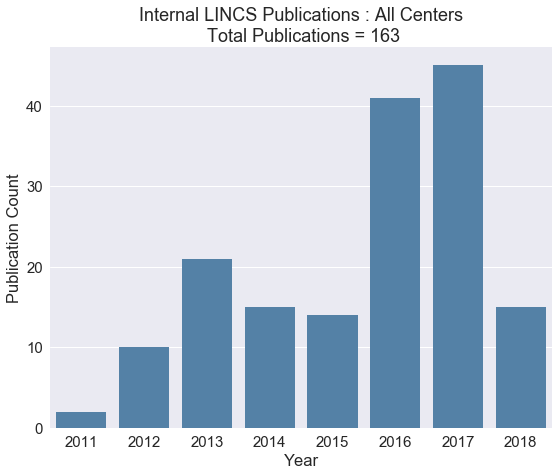

In [84]:
plt.figure(figsize=(9,7)) # Default 8,6 #, dpi=100
years = internal.dropna(subset=['year_published'])['year_published'].astype(int)
years = years[years>1]
sn.countplot( years, color='steelblue')
plt.title('Internal LINCS Publications : All Centers\n Total Publications = '+
          str(len( internal )))
plt.xlabel('Year')
plt.ylabel('Publication Count');
# plt.ylim(0,50);

### Separated By Center

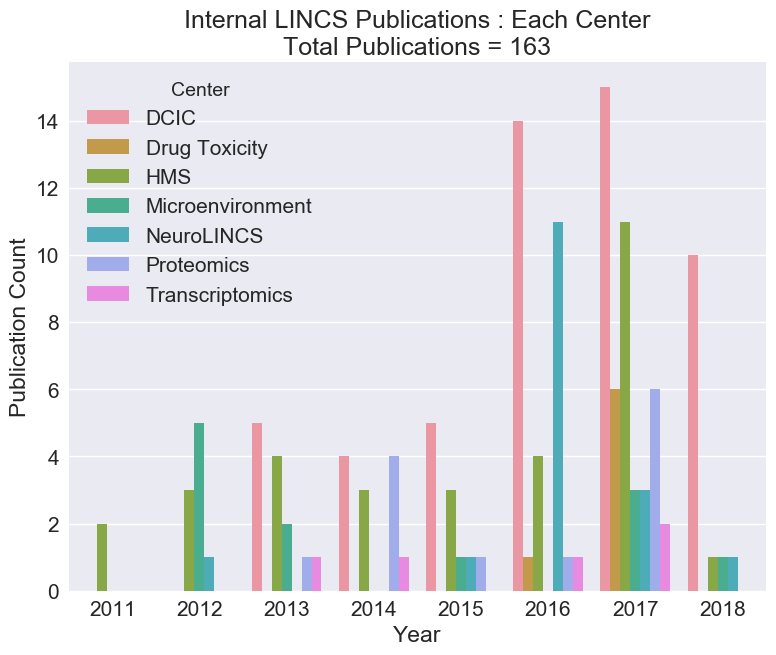

In [85]:
plt.figure(figsize=(9,7), dpi=100) # Default 8,6 #, dpi=100

internalByCenter = {}
for center in Centers: 
    internalByCenter[center] = internal.groupby('year_published')[center].sum()
    
internalByCenter = pd.DataFrame(internalByCenter).stack().reset_index()
internalByCenter.columns = ['year_published', 'Center', 'Count']
internalByCenter['year_published'] = internalByCenter['year_published'].astype(int)
sn.barplot(data=internalByCenter, x='year_published',y='Count',hue='Center')
plt.title('Internal LINCS Publications : Each Center\nTotal Publications = '
          +str(len( internal ) ) )
plt.xlabel('Year')
plt.ylabel('Publication Count');
# plt.ylim(0,10);


## Internal LINCS CITATIONS

### Aggregated Across Centers

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


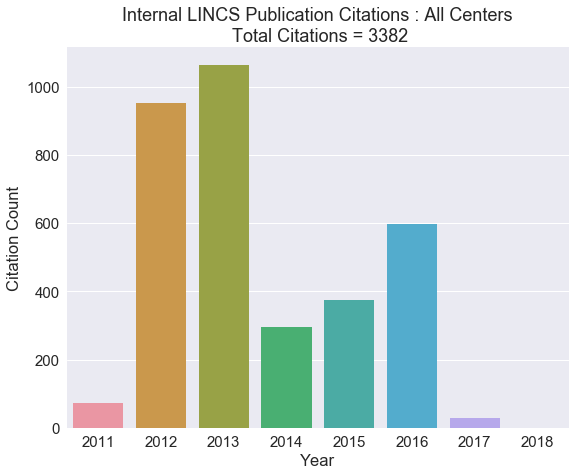

In [86]:
plt.figure(figsize=(9,7)) # Default 8,6 #, dpi=100 
internal['n_citations'] = internal['n_citations'].fillna(0)
internal['year_published'] = internal.loc[:,'year_published'].astype(int)

grouped = internal.groupby('year_published')['n_citations'].sum().reset_index()

sn.barplot(data=grouped, x='year_published', y='n_citations')
plt.title('Internal LINCS Publication Citations : All Centers\n Total Citations = '+\
          str( int(sum(internal['n_citations'])) ))
plt.xlabel('Year')
plt.ylabel('Citation Count'); 
# plt.ylim(0,50);

### Separated By Center

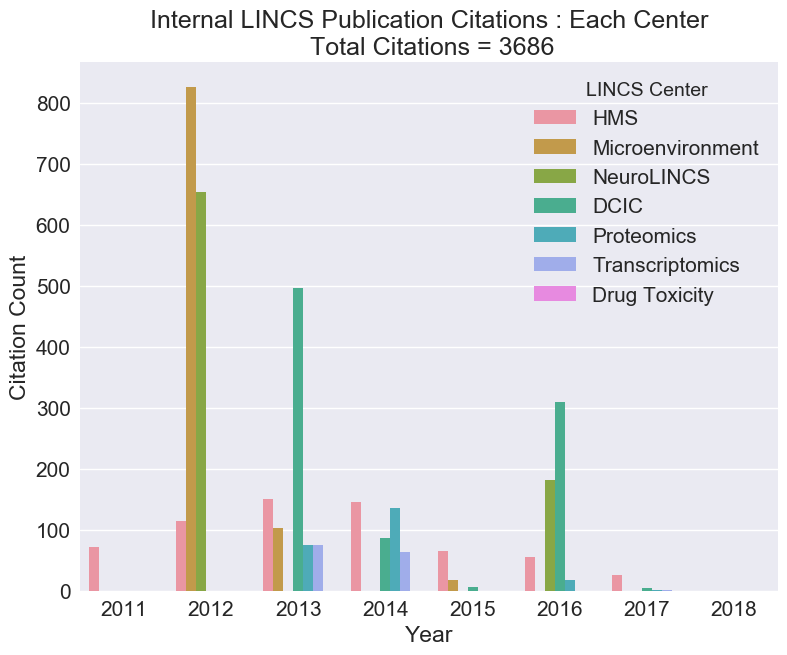

In [87]:
plt.figure(figsize=(9,7), dpi=100) # Default 8,6 #, dpi=100

citationsByCenter={}
for center in Centers:
    citationsByCenter[center] = internal.loc[internal[center]==1,:].groupby(['year_published'])['n_citations'].sum()

citationsByCenter = pd.DataFrame(citationsByCenter).stack().reset_index()
citationsByCenter = citationsByCenter.rename(columns={'level_1':'LINCS Center', 0:'n_citations'})
sn.barplot(data=citationsByCenter, x='year_published', y='n_citations', hue='LINCS Center')
plt.title('Internal LINCS Publication Citations : Each Center\n Total Citations = '+\
          str( int(sum(citationsByCenter['n_citations'])) ))
plt.xlabel('Year')
plt.ylabel('Citation Count');

## External LINCS Publications

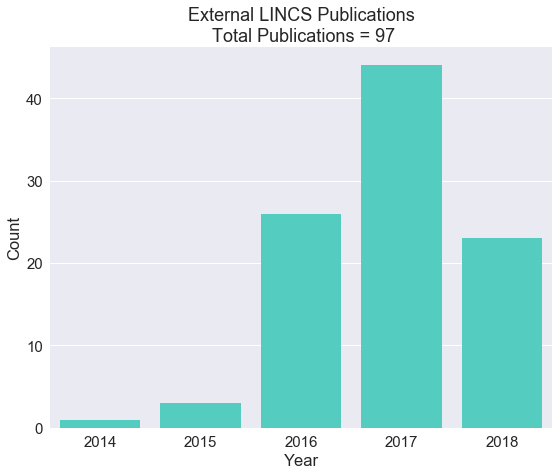

In [88]:
plt.figure(figsize=(9,7)) # Default 8,6 #, dpi=100

years = external.dropna(subset=['year_published'])['year_published'].astype(int)
years = years[years>1]
sn.countplot( years, color='turquoise')
plt.title('External LINCS Publications\n Total Publications = '+str(len(years)))
plt.xlabel('Year')
plt.ylabel('Count');
# plt.ylim(0,50);